In [1]:
import numpy as np
import pandas as pd
import pyampute
from pyampute.ampute import MultivariateAmputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
import os
import matplotlib.pyplot as plt
from sklearn import linear_model

In [2]:
def data_gener(n, mu, ro):
    #continious data
#     mu = np.array([5, 5, 10])
#     mu = np.array([1, 10, 100]) 
#    mu = np.array([1, 100, 10000])
    Sigma = np.array([[1, ro, ro], [ro, 1, ro], [ro, ro, 1]])
    X_cont = np.random.multivariate_normal(mu, Sigma, size = n)

    return X_cont

In [3]:
mu = np.array([5, 5, 10])
cor = 0.3
X_full = data_gener(1000, mu, cor)
X_full

array([[ 5.13435736,  4.19306629,  8.15744151],
       [ 4.11003904,  6.38624442, 11.03730112],
       [ 4.70678394,  6.75052923,  8.67744226],
       ...,
       [ 5.2990572 ,  4.3169219 ,  9.99731936],
       [ 7.0883303 ,  5.34831135, 11.43659176],
       [ 3.45423722,  4.59564222,  7.94046071]])

In [4]:
ma = MultivariateAmputation(
    patterns = [ {'incomplete_vars': [0,1], 'mechanism': "MAR"} ],
    prop = 0.2
)
X_miss = ma.fit_transform(X_full)
X_miss

array([[ 5.13435736,  4.19306629,  8.15744151],
       [        nan,         nan, 11.03730112],
       [ 4.70678394,  6.75052923,  8.67744226],
       ...,
       [ 5.2990572 ,  4.3169219 ,  9.99731936],
       [ 7.0883303 ,  5.34831135, 11.43659176],
       [ 3.45423722,  4.59564222,  7.94046071]])

In [5]:
tmp = pd.DataFrame(X_miss, columns = ['Y1','Y2','X1'])
tmp

,Y1,Y2,X1
0,5.134357,4.193066,8.157442
1,NaN,NaN,11.037301
2,4.706784,6.750529,8.677442
3,5.718540,4.058763,8.962720
4,NaN,NaN,10.650826
...,...,...,...
995,6.253514,5.204777,10.001674
996,5.019831,5.494325,9.920008
997,5.299057,4.316922,9.997319
998,7.088330,5.348311,11.436592


In [7]:
imp1 = IterativeImputer(random_state = 0, estimator = BayesianRidge()).fit_transform(tmp)
pd.DataFrame(imp1, columns = ['Y1','Y2','X1'])

,Y1,Y2,X1
0,5.134357,4.193066,8.157442
1,5.354233,5.401384,11.037301
2,4.706784,6.750529,8.677442
3,5.718540,4.058763,8.962720
4,5.227361,5.269697,10.650826
...,...,...,...
995,6.253514,5.204777,10.001674
996,5.019831,5.494325,9.920008
997,5.299057,4.316922,9.997319
998,7.088330,5.348311,11.436592


In [8]:
imp2 = IterativeImputer(random_state = 9, estimator = BayesianRidge(), sample_posterior = True).fit_transform(tmp)
pd.DataFrame(imp2, columns = ['Y1','Y2','X1'])

,Y1,Y2,X1
0,5.134357,4.193066,8.157442
1,6.515501,4.727593,11.037301
2,4.706784,6.750529,8.677442
3,5.718540,4.058763,8.962720
4,5.466623,5.717746,10.650826
...,...,...,...
995,6.253514,5.204777,10.001674
996,5.019831,5.494325,9.920008
997,5.299057,4.316922,9.997319
998,7.088330,5.348311,11.436592


In [12]:
tmp_sum = (imp2 - imp1).sum()
tmp_sum

-27.85733956109795

In [25]:
def mice_imp(mu, param, num, propor, mech):

    corrs = np.arange(0.1, 1, 0.1)

    df_bias = pd.DataFrame(columns = ['full', mech+str(1), mech+str(2), mech+str(3), mech+str(4)])

    for cor in corrs:

        n = 0
        df_means = pd.DataFrame(columns = ['mean_full', 'mean_M1', 'mean_M2', 'mean_M3', 'mean_M4'])

        for n in np.arange(100):

            X_full = data_gener(1000, mu, cor)
            df_means.loc[n, 'mean_full'] = X_full[:,num].mean() 


            #___MAR1________'incomplete_vars': [0,1], 'weights': [0,0,1]

            ma = MultivariateAmputation(
                patterns = [ {'incomplete_vars': [0,1], 'mechanism': mech} ],
                prop = propor
            )
            X_miss = ma.fit_transform(X_full)
            
            imp = IterativeImputer(random_state = n, estimator = BayesianRidge(), sample_posterior = True).fit_transform(X_miss)
            df_means.loc[n, 'mean_M1'] = imp[:,num].mean()


            
            #___MAR2________'incomplete_vars': [0], 'weights': [0,1,1]

            ma = MultivariateAmputation(
                patterns = [ {'incomplete_vars': [0], 'mechanism': mech} ],
                prop = propor
            )
            X_miss = ma.fit_transform(X_full)

            imp = IterativeImputer(random_state = n, estimator = BayesianRidge(), sample_posterior = True).fit_transform(X_miss)
            df_means.loc[n, 'mean_M2'] = imp[:,num].mean()




            #___MAR3________'incomplete_vars': [1,2], 'weights': [1,0,0]

            ma = MultivariateAmputation(
                patterns = [ {'incomplete_vars': [1,2], 'mechanism': mech} ],
                prop = propor
            )
            X_miss = ma.fit_transform(X_full)

            imp = IterativeImputer(random_state = n, estimator = BayesianRidge(), sample_posterior = True).fit_transform(X_miss)
            df_means.loc[n, 'mean_M3'] = imp[:,num].mean()



            
            #___MAR4________'incomplete_vars': [2], 'weights': [1,1,0]

            ma = MultivariateAmputation(
                patterns = [ {'incomplete_vars': [2], 'mechanism': mech} ],
                prop = propor
            )
            X_miss = ma.fit_transform(X_full)

            imp = IterativeImputer(random_state = n, estimator = BayesianRidge(), sample_posterior = True).fit_transform(X_miss)
            df_means.loc[n, 'mean_M4'] = imp[:,num].mean()


        df_bias.loc[cor, 'full'] = df_means['mean_full'].mean() - df_means['mean_full'].mean() 
        df_bias.loc[cor, mech+str(1)] = df_means['mean_M1'].mean() - df_means['mean_full'].mean()
        df_bias.loc[cor, mech+str(2)] = df_means['mean_M2'].mean() - df_means['mean_full'].mean()
        df_bias.loc[cor, mech+str(3)] = df_means['mean_M3'].mean() - df_means['mean_full'].mean()
        df_bias.loc[cor, mech+str(4)] = df_means['mean_M4'].mean() - df_means['mean_full'].mean()

    return df_bias

In [29]:
mu = np.array([5, 5, 10])

mu_mice_MAR_Y1 = mice_imp(mu = mu, param = "Y1", num = 0, propor = 0.2, mech = "MAR")
# mu_mice_MAR_Y2 = mice_imp(mu = mu, param = "Y2", num = 1, propor = 0.2, mech = "MAR")
# mu_mice_MAR_X1 = mice_imp(mu = mu, param = "X1", num = 2, propor = 0.2, mech = "MAR")
mu_mice_MNAR_Y1 = mice_imp(mu = mu, param = "Y1", num = 0, propor = 0.2, mech = "MNAR")
# mu_mice_MNAR_Y2 = mice_imp(mu = mu, param = "Y2", num = 1, propor = 0.2, mech = "MNAR")
# mu_mice_MNAR_X1 = mice_imp(mu = mu, param = "X1", num = 2, propor = 0.2, mech = "MNAR")

<AxesSubplot:title={'center':'by Y1, MNAR'}>

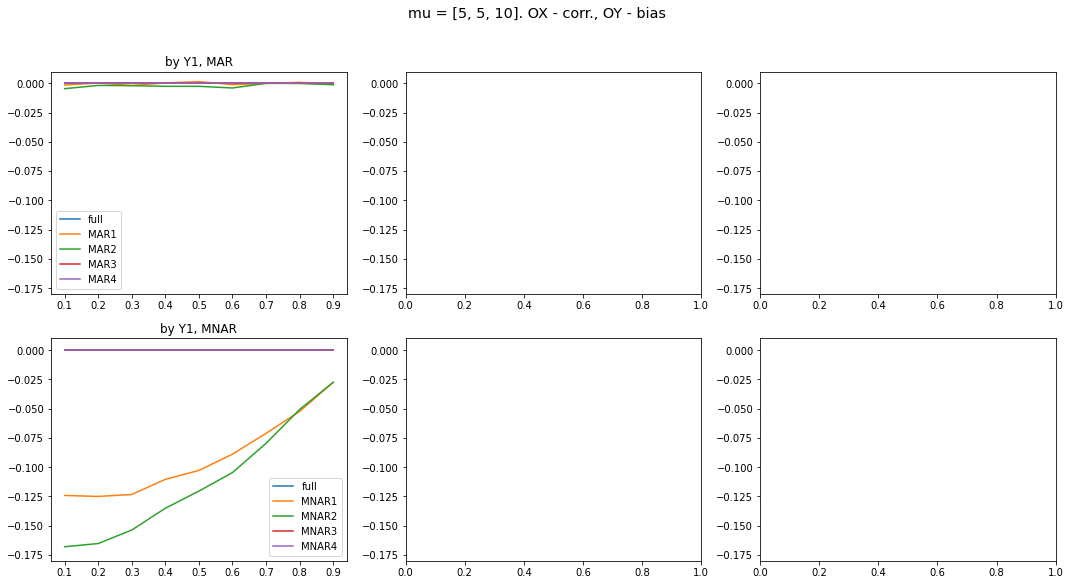

In [30]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize=(6*3,3 * 3))
[ax.set_ylim([-0.18, 0.01]) for ax in axes.flatten()]
fig.suptitle("mu = [5, 5, 10]. OX - corr., OY - bias", fontsize="x-large")

mu_mice_MAR_Y1.plot(ax = axes[0,0], title = "by Y1, MAR")
mu_mice_MNAR_Y1.plot(ax = axes[1,0], title = "by Y1, MNAR")
# mu_mice_MAR_Y2.plot(ax = axes[0,1], title = "by Y2, MAR")
# mu_mice_MNAR_Y2.plot(ax = axes[1,1], title = "by Y2, MNAR")
# mu_mice_MAR_X1.plot(ax = axes[0,2], title = "by X1, MAR")
# mu_mice_MNAR_X1.plot(ax = axes[1,2], title = "by X1, MNAR")